# Visualising surrogate model plotting

This notebook can take the surrogate model pth files and use them to assess how well the GP works. It achieves this by comparing the value for the posterior and variance of each graph to the value provided by the Oracle function. 

## Setup

### Change Working Directory

In [2]:
# Change working directory to the parent of the parent of the script

import os

# Get the current working directory
current_directory = os.getcwd()

# Get the parent of the parent directory
parent_parent_directory = os.path.abspath(os.path.join(current_directory, '..', '..'))

# Change the working directory to the parent of the parent directory
os.chdir(parent_parent_directory)

# Verify the change by printing the new working directory
print("New working directory:", os.getcwd())


New working directory: /Users/Benny/SEGP/Final Revison/bo_molecules


### Imports

In [194]:
# Stadnard Libaires
from collections import OrderedDict

# Third-party
import gpytorch
import torch
import pickle

from tdc import Oracle
from modules.surrogate_models.kernel import WeisfeilerLehmanKernel, EdgeHistogramKernel, WeisfeilerLehmanOptimalAssignmentKernel

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from gauche import NonTensorialInputs

# Custom
from modules.utils.molecular_data_conversion import graph_to_smiles, smiles_to_graph
from modules.surrogate_models.gp_model import initialize_model, GraphGP
from modules.utils.molecular_data_conversion import graph_to_smiles, smiles_to_graph
from modules.surrogate_models.gp_model import initialize_model, GraphGP, optimize_mll
from modules.utils.read_sample_store import read_compressed_or_regular_json, sample_graphs_from_smiles_csv

### Configurations

In [128]:
oracle_name = "mestranol_similarity"
kernel = WeisfeilerLehmanOptimalAssignmentKernel(edge_label='bond', node_label='element')
# kernel = WeisfeilerLehmanOptimalAssignmentKernel(node_label='element', edge_label='bond')

In [129]:
buffer_file_path = "experiments/results/mestranol_similarity/2024-04-28_01-03-19_mestranol_similarity_1000/buffer.json.gz"

## Load Data & Plotting

In [130]:
try:
    objective_function = Oracle(name=oracle_name)
except ValueError:
    raise ValueError(f'The specified objective function {oracle_name} could not be loaded.')

In [131]:
buffer_dict = read_compressed_or_regular_json(buffer_file_path)

print(buffer_dict.keys())

dict_keys(['CC', 'C1=CSC[SH]=C1', 'COC', 'C1=[SH]C=[SH]CS1', 'CCl', 'CON', 'c1css1', 'c1nss1', 'NOF', 'C1=CCC=C1', 'NOON', 'FOCl', 'FCl', 'ClCl', 'CBr', 'BrBr', 'NN', 'CF', 'FF', 'OBr', 'SBr', 'NSN', 'NCl', 'FBr', 'FSF', 'SCl', 'NBr', 'OOF', 'OO', 'SS', 'ClOCl', 'FNF', 'ClBr', 'CN', 'OSO', 'CCO', 'CC(C)(C)C', 'NNN', '[nH]1ss1', 'CS', 'ONCC1CC1', 'C1=NCCNC1', 'FCF', 'FS', 'o1ss1', 'O=CO', 'BrOBr', 'OOO', 'SSS', 'ONOO', '[nH]1os1', 'ClCCl', 'BrNBr', 'o1oo1', 'BrCBr', 'OCl', 'BrSBr', 'NF', 'NC=NN', 'OS', 'ONNO', 'FOF', 'ClCCCl', 'SNCl', 'ClSCl', 'ClNCl', 'BrN(Br)Br', 'BrCC1CC1', 'CC(C)(C)n1ccs1', 'FC(F)F', 'CCCCOC1=[SH]C=CCC1Cl', 'O1OSO1', 'SC1CC1', 'C=C(C=NNC(C)(C)C)NC(=O)NS', 'FN(F)F', 'ClSSCl', 'N=CN=CN', 'ClN(Cl)Cl', 'c1ccoc1', 'O=CCl', 'FC(F)C(F)F', 'ClNN(Cl)Cl', 'COOC', 'NNF', 'SOS', 'NONON', 'Oc1ccc(Cl)cc1O', 'On1oo1', 'CSC', 'SNS', 'C1OOO1', '[nH]1[nH]s1', 'BrSSBr', 'BrN=NBr', 'O1OSS1', '[O-][Br+]O', 'O[Br+]Br', 'CC(C)C', 's1ss1', 'ClC1CC=C[SH]=C1C1=[SH]C=CCC1Cl', 'FSSF', 'OF', 'C

In [132]:
smiles_test = pickle.load(open('experiments/results/mestranol_similarity/2024-04-28_01-03-19_mestranol_similarity_1000/surrogate_model_fitting/graphs_900.pickle', 'rb'))
graph_test = [smiles_to_graph(s) for s in smiles_test]

print('Number of test samples:', len(graph_test))
print(smiles_test)



Number of test samples: 200
['COC12CCC1C=CO[SH]21(CCSCCO)CC=C(C)CC1', 'CC=C(C)C1OCC(=CC)C1C1C=CC2CCC21C', 'C=CS12(CC3=C(O)OCCC3)(C=C(C)CC1)CCC(C)O2', 'CC1=C2C(CO1)C2(N)S12(CC(C)(C)n3ccs3)(CC=CC3(CC3)C1)OCC2C', 'CCCCO[SH]12(C=CC3CCOC(O)=C3O1)C=C(SC)CCO2', 'CC=C(C)C1OCC2=CCC3(C=CC4(S)CCC43C)C2S1', 'CCS12(C3CC3=C(C)OC)(CC=CC3CCC31SC)CCC2C', 'CC=C(C)NC1OCC2=CCC3(C=CC4CCC43CCl)C21', 'CC(O)CCO[SH]12(CCC1C)OCCC1CCC12C', 'CC[SH]1(OC=CC2(C)CC2)(C23CCOC(C)=C2C3)CCC1F', 'CCS12(C3C4=C(C)OCC43)(CC=CC3CCC31SC)NCCC2C', 'CCC(C)CC1C(CO)=CCS12OC=CC1CCC12C', 'CCS12(C3C4=C(C)OCC43)(CC=CC3CCC31C)COCC2C', 'CC1=C2CC2([SH]23(CCC(C4(C)CC4)=CO2)CCC3C)CCO1', 'CCC1=C(C)C2(O)CC2(S23(C)(C=C(C)CN2)CCC3C)C1', 'CCC1=C(C)C2CC2(S23(CC)(CCC2C)OC=CC2=CC4(CCOC4O)OC23C)N=C1', 'CCS12(CC)(C=C(C)CCO1)NC=CC1CCOC(O)=C12', 'CC1=CS23(C=CC4CCOC(O)=C4C2)(CCC3C)OCC1', 'CC1CCS123(OC=CC1CCC12F)OCC=CN3CO', 'C=CC=C1OC(=O)N(C)[SH]12(C)CC=C[SH]21(C)CCC1', 'CC1=C[SH]2(C=CC3CC=[SH]4(OC(=O)CN4C)C3O)(OCC1)OCCN2C', 'CC1CCOS23(C=CC4CCOC(O)=C42)(

In [133]:
print(graph_test[0])
print(graph_test[1])

Graph named 'COC12CCC1C=CO[SH]21(CCSCCO)CC=C(C)CC1' with 22 nodes and 24 edges
Graph named 'CC=C(C)C1OCC(=CC)C1C1C=CC2CCC21C' with 19 nodes and 21 edges


In [134]:
test_orcale_scores = [objective_function(molecule) for molecule in smiles_test]
print('length of test_orcale_scores:', len(test_orcale_scores))

length of test_orcale_scores: 200


In [135]:
list_of_smiles = []
list_of_graphs = []
list_of_y_values = []
for smile in buffer_dict:
    list_of_smiles.append(smile)
    graph = smiles_to_graph(smile)
    list_of_graphs.append(graph)
    list_of_y_values.append(buffer_dict[smile][0])

In [165]:
# Calculate initial objective function scores
y_train = np.array(list_of_y_values[0:900], dtype=np.float64)

# Convert labels to PyTorch tensors
y_train = torch.from_numpy(y_train).float()

likelihood = gpytorch.likelihoods.GaussianLikelihood()
x_train_nti = NonTensorialInputs(list_of_graphs[0:900])
mll, model = initialize_model(x_train_nti, y_train, GraphGP, likelihood, kernel)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [166]:
model = optimize_mll(mll, model, optimizer)



In [164]:
# torch.save(model.state_dict(), 'graph_gp_model.pth')

### Getting predicted values for the grpahs 

In [175]:
model.eval()
model.likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_test_nti = NonTensorialInputs(graph_test)
# surrogate_labels_train = model(x_train_nti)
    surrogate_labels_test = model(x_test_nti)

In [183]:
print('surrogate_labels_test:', surrogate_labels_test.variance)

surrogate_labels_test: tensor([0.6707, 0.6072, 0.6359, 0.6638, 0.6612, 0.6519, 0.6362, 0.6558, 0.6048,
        0.6625, 0.6253, 0.5355, 0.6094, 0.6365, 0.6738, 0.6511, 0.6149, 0.5365,
        0.6997, 0.7031, 0.7045, 0.4923, 0.6181, 0.5778, 0.5857, 0.6256, 0.7984,
        0.6246, 0.5873, 0.7719, 0.6312, 0.6697, 0.6061, 0.6332, 0.6177, 0.6173,
        0.6644, 0.6653, 0.6126, 0.7227, 0.6131, 0.6074, 0.6797, 0.6023, 0.6203,
        0.5995, 0.8486, 0.5972, 0.4680, 0.7087, 0.5789, 0.6532, 0.6496, 0.6520,
        0.8534, 0.5567, 0.6813, 0.6146, 0.5837, 0.6335, 0.5881, 0.6380, 0.6646,
        0.5094, 0.5833, 0.6691, 0.6180, 0.6465, 0.6078, 0.7012, 0.6759, 0.6124,
        0.8406, 0.6617, 0.7924, 0.6140, 0.6111, 0.6512, 0.5891, 0.6540, 0.6004,
        0.5166, 0.6528, 0.6435, 0.6391, 0.6338, 0.6035, 0.7060, 0.7294, 0.5348,
        0.6871, 0.6486, 0.5675, 0.6910, 0.6709, 0.5579, 0.6839, 0.5015, 0.5910,
        0.5455, 0.7132, 0.6033, 0.5331, 0.6125, 0.6334, 0.6666, 0.6775, 0.5311,
        0.5708, 0

In [199]:
zinc_graphs, zinc_smiles = sample_graphs_from_smiles_csv(
            filepath='data/zinc_1000_sample.csv', 
            sample_size=50)

Sampled 50 graphs from data/zinc_1000_sample.csv


In [201]:
model.eval()
model.likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_zinc_nti = NonTensorialInputs(zinc_graphs)
    surrogate_labels_zinc = model(x_zinc_nti)
    
    

In [204]:
zinc_oracle_scores = [objective_function(molecule) for molecule in zinc_smiles]

### Plotting

In [ ]:
import seaborn as sns
sns.set_context('paper', rc={'font.size': 14, 'axes.titlesize': 12, 'axes.labelsize': 14})
sns.set_style('ticks')

### Points from the GA

MSE: 0.0013575882898314794
R2: 0.8803378166801124
RMSE: 0.036845464983244265


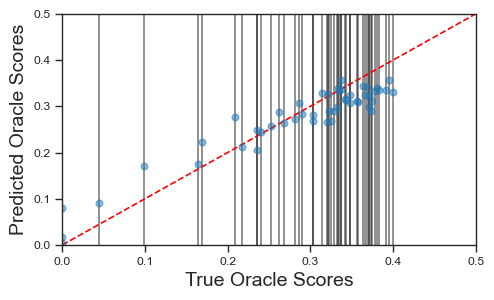

In [220]:
plt.figure(figsize=(16/3, 3))
yerr = (surrogate_labels_test.variance.detach().numpy()[0:50])
plt.errorbar(test_orcale_scores[0:50], surrogate_labels_test.mean.detach().numpy()[0:50], yerr=yerr, fmt='o', ecolor='k', capthick=0.5, capsize=2, alpha=0.5)
plt.xlabel('True Oracle Scores')
plt.ylabel('Predicted Oracle Scores')
plt.ylim(0, 0.5)
plt.xlim(0, 0.5)

print(f'MSE: {mean_squared_error(test_orcale_scores, surrogate_labels_test.mean.detach().numpy())}')
print(f'R2: {r2_score(test_orcale_scores, surrogate_labels_test.mean.detach().numpy())}')
print(f'RMSE: {np.sqrt(mean_squared_error(test_orcale_scores, surrogate_labels_test.mean.detach().numpy()))}')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
# plt.plot(np.unique(test_orcale_scores), np.poly1d(np.polyfit(test_orcale_scores, surrogate_labels_test.mean.detach().numpy(), 1))(np.unique(test_orcale_scores)))


### Points sampled from zinc

MSE: 0.003994874342264446
R2: 0.08303803352275174
RMSE: 0.06320501833133542


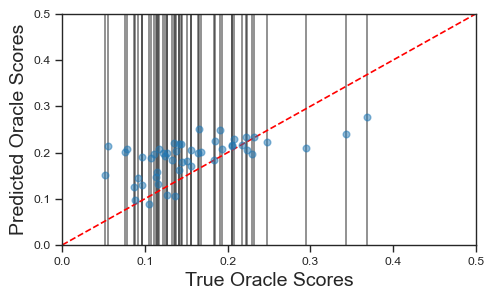

In [221]:
plt.figure(figsize=(16/3, 3))
yerr = (surrogate_labels_zinc.variance.detach().numpy()[0:50])
plt.errorbar(zinc_oracle_scores[0:50], surrogate_labels_zinc.mean.detach().numpy()[0:50], yerr=yerr, fmt='o', ecolor='k', capthick=0.5, capsize=2, alpha=0.5)
plt.xlabel('True Oracle Scores')
plt.ylabel('Predicted Oracle Scores')
plt.ylim(0, 0.5)
plt.xlim(0, 0.5)

print(f'MSE: {mean_squared_error(zinc_oracle_scores, surrogate_labels_zinc.mean.detach().numpy())}')
print(f'R2: {r2_score(zinc_oracle_scores, surrogate_labels_zinc.mean.detach().numpy())}')
print(f'RMSE: {np.sqrt(mean_squared_error(zinc_oracle_scores, surrogate_labels_zinc.mean.detach().numpy()))}')

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
# plt.plot(np.unique(test_orcale_scores), np.poly1d(np.polyfit(test_orcale_scores, surrogate_labels_test.mean.detach().numpy(), 1))(np.unique(test_orcale_scores)))


In [178]:
print()
print(type(test_orcale_scores[0:100])) 
print(type(surrogate_labels_test.mean.detach().numpy()[0:100]))

# plt.fill_between(np.sort(test_orcale_scores[0:100]), np.sort(surrogate_labels_test.mean.detach().numpy()[0:100] - 1.96*yerr[0:100]), np.sort(surrogate_labels_test.mean.detach().numpy()[0:100] + 1.96*yerr[0:100]), alpha=0.5)


AE = (np.abs(test_orcale_scores - surrogate_labels_test.mean.detach().numpy()))
print(type(AE))
AE_stds_from_pp =  (surrogate_labels_test.variance.detach().numpy())

bins = np.linspace(0,1, 20)

def get_indcies(AE_stds_from_pp, bins):
    indexes = []
    for i in range(len(bins)-1):
        indexes.append(np.where((AE_stds_from_pp >= bins[i]) & (AE_stds_from_pp < bins[i+1]))[0])
    return indexes

indixes = get_indcies(AE_stds_from_pp, bins)
print(type(indixes))



<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


In [179]:
MAE = []
MAE_std = []
for binned_vals in indixes:
    MAE.append(np.mean(AE[binned_vals]))
    std = np.std(AE[binned_vals])
    root_n = np.sqrt(len(binned_vals))
    MAE_std.append(std/root_n)

    

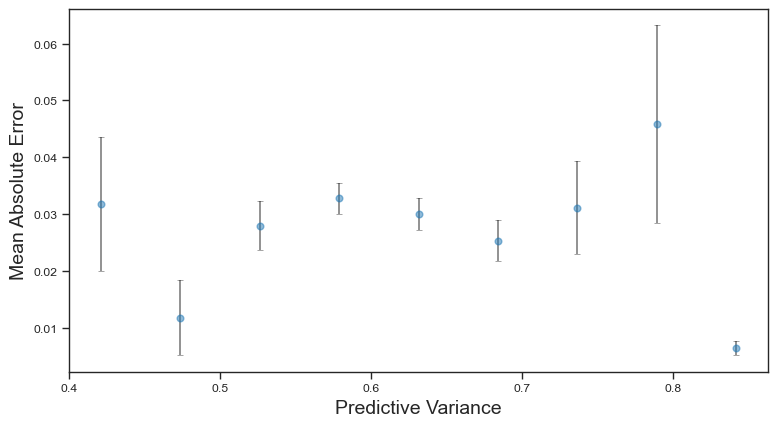

In [180]:
import seaborn as sns

sns.set_context('paper', rc={'font.size': 14, 'axes.titlesize': 12, 'axes.labelsize': 14})
sns.set_style('ticks')

plt.figure(figsize=(8, 4.5))
plt.ylabel('Mean Absolute Error')
plt.xlabel('Predictive Variance')
plt.errorbar(bins[:-1], MAE, yerr=MAE_std, fmt='o', ecolor='k', capthick=0.5, capsize=2, alpha=0.5)

plt.tight_layout()

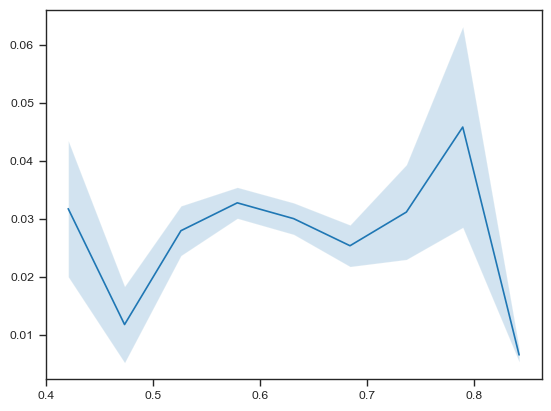

In [173]:
lower = np.array(MAE) - np.array(MAE_std)
upper = np.array(MAE) + np.array(MAE_std)

plt.plot(bins[:-1], MAE, label='mean')
plt.fill_between(bins[:-1], lower, upper, alpha=0.2)